In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
from sklearn.model_selection import train_test_split

In [33]:
df = pd.read_csv('bhd.csv')

In [34]:
df1 = df.drop(['area_type', 'availability', 'balcony', 'society'], axis=1)

df2 = df1.dropna(axis=0).copy()

In [35]:
def extract_0(x):
    return str(x).split(' ')[0]

df2['size'] = df2['size'].apply(extract_0).astype(int)
# lambda x: int(str(x).split(' ')[0])

In [36]:
def av_(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None
    
    
df2['total_sqft'] = df2['total_sqft'].apply(av_)
df2

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2,1056.0,2.0,39.07
1,Chikka Tirupathi,4,2600.0,5.0,120.00
2,Uttarahalli,3,1440.0,2.0,62.00
3,Lingadheeranahalli,3,1521.0,3.0,95.00
4,Kothanur,2,1200.0,2.0,51.00
...,...,...,...,...,...
13315,Whitefield,5,3453.0,4.0,231.00
13316,Richards Town,4,3600.0,5.0,400.00
13317,Raja Rajeshwari Nagar,2,1141.0,2.0,60.00
13318,Padmanabhanagar,4,4689.0,4.0,488.00


In [37]:
df3 = df2.copy()
df3['price_per_sqft'] = df3['price']*10000 / df3['total_sqft']

df3['location'] = df3['location'].apply(lambda x: x.strip())
location_stats =  df3.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats_less_than_10 = location_stats[location_stats<10]

In [38]:
df3.location = df3['location'].apply(
    lambda x: 'Other location' 
    if x in location_stats_less_than_10 else x)

len(df3['location'].unique())

255

In [39]:
#Removing some outliers using domain knoledge
df4 = df3[~((df3['total_sqft']/df3['size'])<300)]
df4.shape

(12502, 6)

In [40]:
def remove_price_per_sq_outliers(dataframe):
    df_out = pd.DataFrame()
    for key, sub_df in dataframe.groupby('location'):
        m = np.mean(sub_df['price_per_sqft'])
        st = np.std(sub_df['price_per_sqft'])
        reduced_df = sub_df[(sub_df['price_per_sqft']>(m-st)) & (sub_df['price_per_sqft']<=(m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out
df5 = remove_price_per_sq_outliers(df4)
df5.shape

(10222, 6)

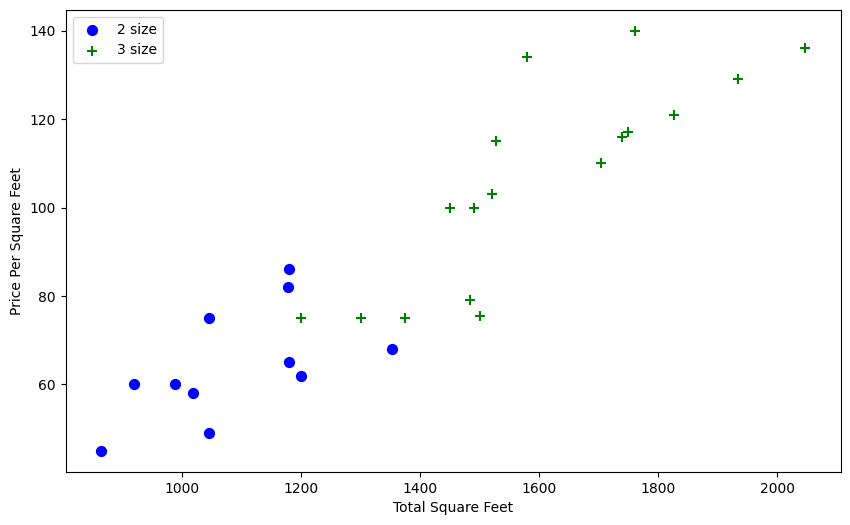

In [41]:
def plot_scatter_chart(dataframe, location):
    size2 = dataframe[(dataframe['location'] == location) & (dataframe['size'] == 2)]
    size3 = dataframe[(dataframe['location'] == location) & (dataframe['size'] == 3)]
    plt.figure(figsize=(10,6))
    plt.scatter(size2.total_sqft, size2.price, color='blue', label='2 size', s=50)
    plt.scatter(size3.total_sqft, size3.price, color='green', marker='+', label='3 size', s=50)
    plt.xlabel('Total Square Feet')
    plt.ylabel('Price Per Square Feet')
    plt.legend()
plot_scatter_chart(df5, 'Vijayanagar')

In [42]:
def remove_bedroom_outliers(dataframe):
    exclude_indices = np.array([])
    for location, df_location in dataframe.groupby('location'):
        bedroom_stat = {}
        for bedroom, df_bedroom in df_location.groupby('size'):
            bedroom_stat[bedroom] = {
                'mean': np.mean(df_bedroom['price_per_sqft']),
                'std': np.std(df_bedroom['price_per_sqft']),
                'count': df_bedroom.shape[0]
            }
        for bedroom, df_bedroom in df_location.groupby('size'):
            stats = bedroom_stat.get(bedroom-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, df_bedroom[df_bedroom['price_per_sqft']<(stats['mean'])].index.values)
    return dataframe.drop(exclude_indices, axis = 'index')

df6 = remove_bedroom_outliers(df5)
df6.shape

(7369, 6)

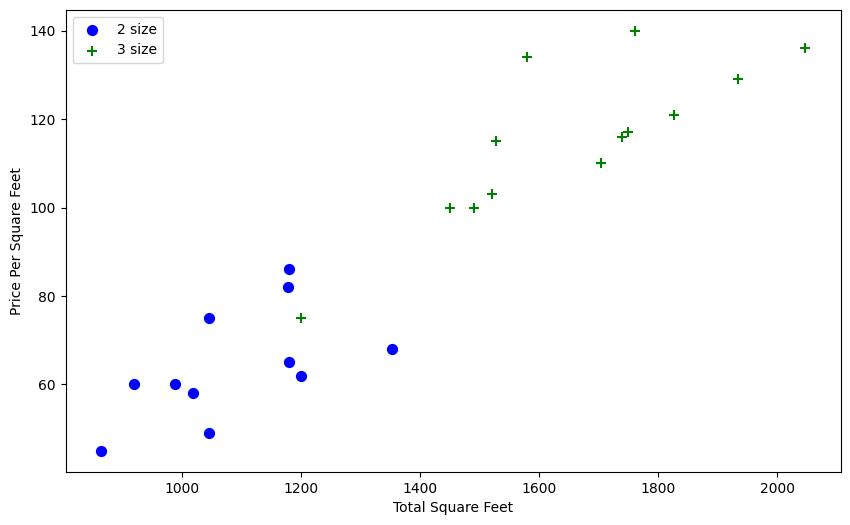

In [43]:
plot_scatter_chart(df6, 'Vijayanagar')

In [44]:
# Removing Outliers of Bathroom Greater Than Bedroom + 2 in Our Data Set
df7 = df6[~(df6['bath']>(df6['size'] + 2))]
df7.shape

(7364, 6)

In [45]:
df8 = df7.drop('price_per_sqft', axis=1)
df8['location'] = df8['location'].apply(lambda x: x.strip().lower())
df8.head(5)

,location,size,total_sqft,bath,price
0,1st block jayanagar,4,2850.0,4.0,428.0
1,1st block jayanagar,3,1630.0,3.0,194.0
2,1st block jayanagar,3,1875.0,2.0,235.0
3,1st block jayanagar,3,1200.0,2.0,130.0
4,1st block jayanagar,2,1235.0,2.0,148.0


In [46]:
# df8[df8['total_sqft']<=df8['total_sqft'].min()+100]

In [47]:
df_dummies = pd.get_dummies(df8['location'], dtype='int')

In [48]:
print('other location' in df_dummies.columns)

True


In [49]:
# Ensure 'other location' is always a column in your dummies
if 'other location' not in df_dummies.columns:
    df_dummies['other location'] = 0

In [50]:
df10 = pd.concat([df8, df_dummies], axis=1)
df10.drop('location', axis=1, inplace=True)

In [51]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

X = df10.drop('price', axis=1)
y = df10.price

scaler = StandardScaler().fit(X)
l_model = RandomForestRegressor(criterion='poisson', max_depth=50)
X_scale = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=.25, random_state=42)
c_v = ShuffleSplit(n_splits=5, test_size=.25, random_state=42)
cv_score = cross_val_score(RandomForestRegressor(criterion='poisson', max_depth=50), X, y, cv=c_v)
score = cv_score.mean()
l_model.fit(X_train, y_train)

print(l_model.score(X_train, y_train))
print(l_model.score(X_test, y_test))


0.9583258913219138
0.8975585887975404


In [52]:
def predict_price(location, total_sqft, size, bath):
    x = np.zeros(len(X.columns))
    try:
        size_idx = X.columns.get_loc('size')
        sqft_idx = X.columns.get_loc('total_sqft')
        bath_idx = X.columns.get_loc('bath')
    except Exception as e:
        raise Exception("Column order mismatch: " + str(e))
    x[size_idx] = size
    x[sqft_idx] = total_sqft
    x[bath_idx] = bath
    if location in X.columns:
        loc_idx = X.columns.get_loc(location)
        x[loc_idx] = 1
    x_df = pd.DataFrame([x], columns=X.columns)
    x_scaled = scaler.transform(x_df)
    pred = l_model.predict(x_scaled)[0]
    return max(0, pred)  # Prevent negative predictions
print(predict_price('indira nagar', 5, 3, 3))


55.786


In [53]:
def get_the_best_model(X, y):
    algo = {
        'linear_R':{
            'model':LinearRegression(),
            'params':{
                'positive':[True, False]
            }
        },

        'Desicion_T':{
            'model':DecisionTreeRegressor(),
            'params':{
                'criterion':['absolute_error', 'friedman_mse'],
                'splitter':['random', 'best']
            }
        },

        'Lasso':{
            'model':Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random', 'cyclic']
            }
        }
    }

    scores = []
    c_v = ShuffleSplit(n_splits=5, test_size=.25, random_state=42)
    for algo_name, configure in algo.items():
        gri = GridSearchCV(configure['model'], configure['params'], return_train_score=False, error_score='raise')
        gri.fit(X, y)
        scores.append(
            {
            'model':algo_name,
            'best_score':gri.best_score_,
            'best_parameters':gri.best_params_
            }
        )

    return pd.DataFrame(scores, columns=[ 'model','best_score','best_parameters'])

In [54]:
# get_the_best_model(X_train, y_train)

In [59]:
df8

,location,size,total_sqft,bath,price
0,1st block jayanagar,4,2850.0,4.0,428.0
1,1st block jayanagar,3,1630.0,3.0,194.0
2,1st block jayanagar,3,1875.0,2.0,235.0
3,1st block jayanagar,3,1200.0,2.0,130.0
4,1st block jayanagar,2,1235.0,2.0,148.0
...,...,...,...,...,...
10211,yeshwanthpur,2,1195.0,2.0,100.0
10212,yeshwanthpur,3,1692.0,3.0,108.0
10214,yeshwanthpur,6,2500.0,5.0,185.0
10219,yeshwanthpur,3,1855.0,3.0,135.0


In [55]:

def predict_price(location, total_sqft, size, bath):
    x = np.zeros(len(X.columns))
    try:
        size_idx = X.columns.get_loc('size')
        sqft_idx = X.columns.get_loc('total_sqft')
        bath_idx = X.columns.get_loc('bath')
    except Exception as e:
        raise Exception("Column order mismatch: " + str(e))
    x[size_idx] = size
    x[sqft_idx] = total_sqft
    x[bath_idx] = bath
    if location in X.columns:
        loc_idx = X.columns.get_loc(location)
        x[loc_idx] = 1
    # Convert to DataFrame with correct columns
    x_df = pd.DataFrame([x], columns=X.columns)
    x_scaled = scaler.transform(x_df)
    return l_model.predict(x_scaled)[0]
try:
    print(predict_price('Indira Nagar', 1555, 3, 3))
except Exception as e:
    print(e)

77.72248685349808


In [56]:
with open('bhd_model.pickle', 'wb') as f:
    pickle.dump(l_model, f)

    
columns = {
    'data_column': [col for col in X.columns]
}
with open('data_columns.json', 'w') as f:
    f.write(json.dumps(columns))
    
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)